# Progetto Visualizzazione Scientifica

# Accessibilità

Categorie:
- Accorgimenti presenti in generale ( i dati successivi sono presenti solo se questa è a si )

- accesso esterno con rampe
- Ascensore per il trasporto disabili
- Servoscala piattaforma elevatrice
- servizi igienici per disabili


GRAFICI:
- barchart categorie servizi
- 1: Linechart in cui per ogni servizi indichiamo la percentuale di scuole che lo offrono; così identifichiamo i servizi meno diffusi e quindi critici, e se queste percentuali sono cambiate nel tempo.
- 2: cartina in cui per ogni regione calcoliamo la percentuale di scuole che in generale hanno accorgimenti 
- 3: potremmo fare una cartina per ogni servizio (magari non per tutti, per i principali, tipo accesso con rampe, servo scala o ascensore e servizi igienici) oppure magari una cartina in cui mettiamo la percentuale di scuole che hanno un set "base" (tipo rampe + ascensore o servoscala e servizi) di accorgimenti, e sulla base di quest'ultima scegliamo la regione critica

- pie-chart

REGIONE CRITICA:
- 4: linechart in cui vediamo se la percentuale di scuole che presenta il set base di accorgimenti è variato nel tempo
- 5: cartina a livello provinciale, per vedere se la carenza è localizzata o generale.


Problematicità: come trattiamo i non definiti? li includiamo nel totale? io li includerei come no; è vero che bisognerebbe dare il beneficio del dubbio, ma volendo dichiarare quante scuole, secondo i dati, presentano questi servizi, il non definito mi pare più un no che un si; il motivo per cui è non definito è una problematica relativa alla raccolta dei dati.
Quindi le percentuali le farei SI / SI + NO + NON DEFINITO
Comunque durante la presentazione dovremmo far presente di questa cosa e giustificare la scelta fatta


### import librerie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.text import Text
import matplotlib.patches as mpatches
import geopandas as gpd
import mapclassify as mc
import folium
from shapely.geometry import Polygon, Point
import matplotlib.colors as mcolors

data_dir = "./dataset/"
img_dir = "./img/"

### Colormap

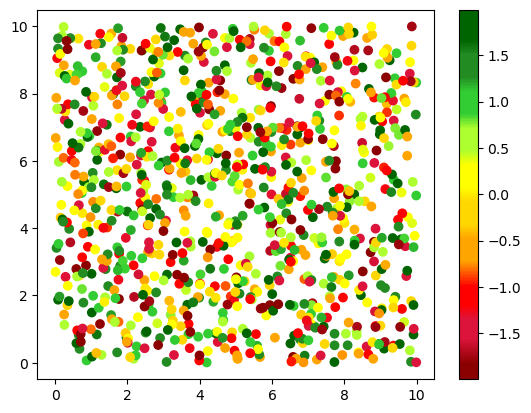

In [2]:
def make_colormap(seq):
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
cm = make_colormap([c('darkred'), 0.04, c('darkred'), c('crimson'), 0.11, c('crimson'), 0.16, c('crimson'), c('r'), 0.20,
                    c('r'), 0.25, c('r'), c('orange'), 0.32, c('orange'), 0.38, c('orange'), c('gold'), 0.42, c('gold'), 0.48,
                    c('gold'), c('yellow'), 0.52, c('yellow'), 0.58, c('yellow'), c('greenyellow'), 0.62, c('greenyellow'),
                    0.68, c('greenyellow'), c('limegreen'), 0.72, c('limegreen'), 0.78, c('limegreen'), c('forestgreen'), 0.82,
                    c('forestgreen'), 0.88,c('forestgreen'), c('darkgreen'), 0.92, c('darkgreen')])
N = 1000
array_dg = np.random.uniform(0, 10, size=(N, 2))
colors = np.random.uniform(-2, 2, size=(N,))
plt.scatter(array_dg[:, 0], array_dg[:, 1], c=colors, cmap=cm)
plt.colorbar()
plt.show()

## Funzioni utili ( private )

In [3]:
# Funzione che modifica i nomi delle colonne di "da_modificare" con i nomi delle corrispondenti colonne di "base"
def make_consistent(base, da_modificare):
    for i in range(min(base.columns.size, da_modificare.columns.size)):
        # check if columns name are equal
        if(base.columns[i] != da_modificare.columns[i]):
            # rename column
            da_modificare.rename(columns = {da_modificare.columns[i]:base.columns[i]}, inplace=True)

# Funzione che verifica che due dataset abbiano lo stesso numero di colonne e con gli stessi nomi 
def check_same_shape(a, b):
    size = min(a.columns.size, b.columns.size)
    return np.all(a.columns[:size] == b.columns[:size])

def get_province_by_region(regione, elenco_province):
    return elenco_province[elenco_province.regione == regione].sigla.to_numpy()
def get_scuole_by_province(province, elenco_scuole):
    return elenco_scuole[elenco_scuole.SIGLAPROVINCIA.isin(province)]

## Funzioni utili ( public )

In [4]:
def get_scuole_by_region(regione, elenco_scuole, elenco_province):
    return get_scuole_by_province(get_province_by_region(regione, elenco_province), elenco_scuole)

def cartina(get_dati_function, regioni, title):
    # add data to italy dataset
    regioni['DATA'] = regioni.DEN_REG.apply(lambda x: get_dati_function(x))
    
    # get no data regions
    nodata = regioni[regioni.DATA == 0]
    regioni = regioni.drop(regioni[regioni.DATA == 0].index)
    
    # set up cartina
    fig, ax = plt.subplots(1, figsize=(8, 16))
    ax.set_axis_off()
    plt.title(title)
    cmap=cm
    bins_size=11
    
    # bins
    bins = np.linspace(0, 100, bins_size)
    
    #plot
    regioni.plot(column='DATA', cmap=cmap, ax=ax,
             edgecolor='black', linewidth=1, 
             scheme="User_Defined", 
             classification_kwds=dict(bins=bins),
             legend=True, legend_kwds={'title': "legend"} )
    
 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    
    patches = []
    for i in range(bins_size - 1):
        patches.append(mpatches.Patch(color=sm.to_rgba(bins[i]),
                                      label=(str(round(bins[i])) + ' - ' + str(round(bins[i + 1])) + " %") ) )

    patches.append(mpatches.Patch(color='none'))
    patches.append(mpatches.Patch(color='lightgray', label='no data'))
    ax.legend(handles=patches, loc="best", prop={'size':9})
    nodata.plot(color='lightgray', ax=ax, edgecolor='black', linewidth=1)
    
    
def autolabel(rects):
    for rect in rects:
        height = round(rect.get_height())
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 10),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=15)
    
    
shape_regioni = gpd.read_file(filename=(data_dir + 'regioni_shape/regioni.shp'))

# Import DataSet

In [5]:
# ***************************** #
# ********* ELENCO ************ # 
# ***************************** #

elenco_scuole = pd.read_csv(data_dir + "elenco_scuole_italia.csv")

# ***************************** #
# ********* PROVINCE ********** # 
# ***************************** #

elenco_province = pd.read_csv(data_dir + "province.csv", encoding='latin-1')
elenco_regioni = elenco_province.regione.unique()

# ***************************** #
# * BARRIERE ARCHITETTONICHE ** # 
# ***************************** #
ba_1718 = pd.read_csv(data_dir + "barriere_architettoniche_italia_1718.csv")
ba_1819 = pd.read_csv(data_dir + "barriere_architettoniche_italia_1819.csv")
ba_2021 = pd.read_csv(data_dir + "barriere_architettoniche_italia_2021.csv")
ba_2122 = pd.read_csv(data_dir + "barriere_architettoniche_italia_2122.csv")

# MODIFICHE
# drop last column ( "ALTRO", difficile da analizzare)
ba_1718.drop(columns=[ba_1718.columns[ba_1718.columns.size - 1]], inplace=True)
ba_1819.drop(columns=[ba_1819.columns[ba_1819.columns.size - 1]], inplace=True)
ba_2021.drop(columns=[ba_2021.columns[ba_2021.columns.size - 1]], inplace=True)
ba_2122.drop(columns=[ba_2122.columns[ba_2122.columns.size - 1]], inplace=True)

# modifica nomi degli attributi 
make_consistent(ba_2021, ba_1819)
make_consistent(ba_2021, ba_1718)


#####################################################################################


### PRINT STUFF
print('SCHEMA DATASET BARRIERE ARCHITETTONICHE', ba_1819.columns)
print("\n\n\n")
print('SCHEMA ELENCO SCUOLE', elenco_scuole.columns)
print("\n\n\n")
print('SCHEMA province', elenco_province.columns)

SCHEMA DATASET BARRIERE ARCHITETTONICHE Index(['ANNOSCOLASTICO', 'CODICESCUOLA', 'CODICEEDIFICIO',
       'ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE',
       'ACCESSODAESTERNOCONRAMPE', 'SCALEANORMA', 'ASCENSORETRASPORTODISABILI',
       'SERVOSCALAPIATTAFORMAELEVATRICE',
       'SERVIZIIGIENICISPECIFICINORMADISABILI', 'PORTELARGHEZZAMINIMA',
       'PERCORSIINTERNI', 'PERCORSIESTERNI'],
      dtype='object')




SCHEMA ELENCO SCUOLE Index(['ANNOSCOLASTICO', 'CODICESCUOLA', 'CODICEEDIFICIO', 'CODICECOMUNE',
       'DESCRIZIONECOMUNE', 'SIGLAPROVINCIA', 'TIPOLOGIAINDIRIZZO',
       'DENOMINAZIONEINDIRIZZO', 'NUMEROCIVICO', 'CAP'],
      dtype='object')




SCHEMA province Index(['provincia', 'regione', 'sigla'], dtype='object')


## codici tipo di scuola

In [6]:
licei = ['PC', 'PL', 'PS', 'SL']
istituti_tecnici = ['TA', 'TB', 'TD', 'TE', 'TF', 'TH', 'TL', 'TN']
istituti_professionali = ['RA', 'RB', 'RC', 'RE', 'RF', 'RH', 'RI', 'RM', 'RN', 'RS', 'RT', 'RV']
# area_artistica = ['SD', 'SM', 'SN', 'SR', 'ST']
media = ['MM']
elementari = ['EE']
istituto_comprensivo = ['IC']
superiori = ['IS']
# scuola_materna = ['AA']  togliamo
# magistrali = ['PM', 'PQ'] togliamo
# altri = ['VC', 'VE'] togliamo

codici_elementari = elementari + istituto_comprensivo
codici_medie = media + istituto_comprensivo
codici_superiori = superiori + istituti_professionali + istituti_tecnici + licei


######### CODICI DI INTERESSE #########
codici = codici_elementari + codici_medie + codici_superiori

def get_elementari(df):
    return df[df.CODICESCUOLA.str[2:4].isin(codici_elementari)]
def get_medie(df):
    return df[df.CODICESCUOLA.str[2:4].isin(codici_medie)]
def get_superiori(df):
    return df[df.CODICESCUOLA.str[2:4].isin(codici_superiori)]
def get_scuole_di_interesse(df):
    return df[df.CODICESCUOLA.str[2:4].isin(codici)]

# Dati utili

In [7]:
years_labels = ['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022'] 
tipi_scuole_labels = ['Elementari', 'Medie', 'Superiori']

In [8]:
ba_1718 = get_scuole_di_interesse(ba_1718)
ba_1819 = get_scuole_di_interesse(ba_1819)
ba_2021 = get_scuole_di_interesse(ba_2021)
ba_2122 = get_scuole_di_interesse(ba_2122)

ba_1718 = pd.merge(ba_1718, elenco_scuole, on="CODICESCUOLA")
ba_1718 = ba_1718.drop_duplicates(subset=['CODICESCUOLA', 'CODICEEDIFICIO_x'])

ba_1819 = pd.merge(ba_1819, elenco_scuole, on="CODICESCUOLA")
ba_1819 = ba_1819.drop_duplicates(subset=['CODICESCUOLA', 'CODICEEDIFICIO_x'])

ba_2021 = pd.merge(ba_2021, elenco_scuole, on="CODICESCUOLA")
ba_2021 = ba_2021.drop_duplicates(subset=['CODICESCUOLA', 'CODICEEDIFICIO_x'])

ba_2122 = pd.merge(ba_2122, elenco_scuole, on="CODICESCUOLA")
ba_2122 = ba_2122.drop_duplicates(subset=['CODICESCUOLA', 'CODICEEDIFICIO_x'])

totale_scuole = len(ba_2122)

## Barchart - percentuale di scuole per ogni tipo di accorgimento

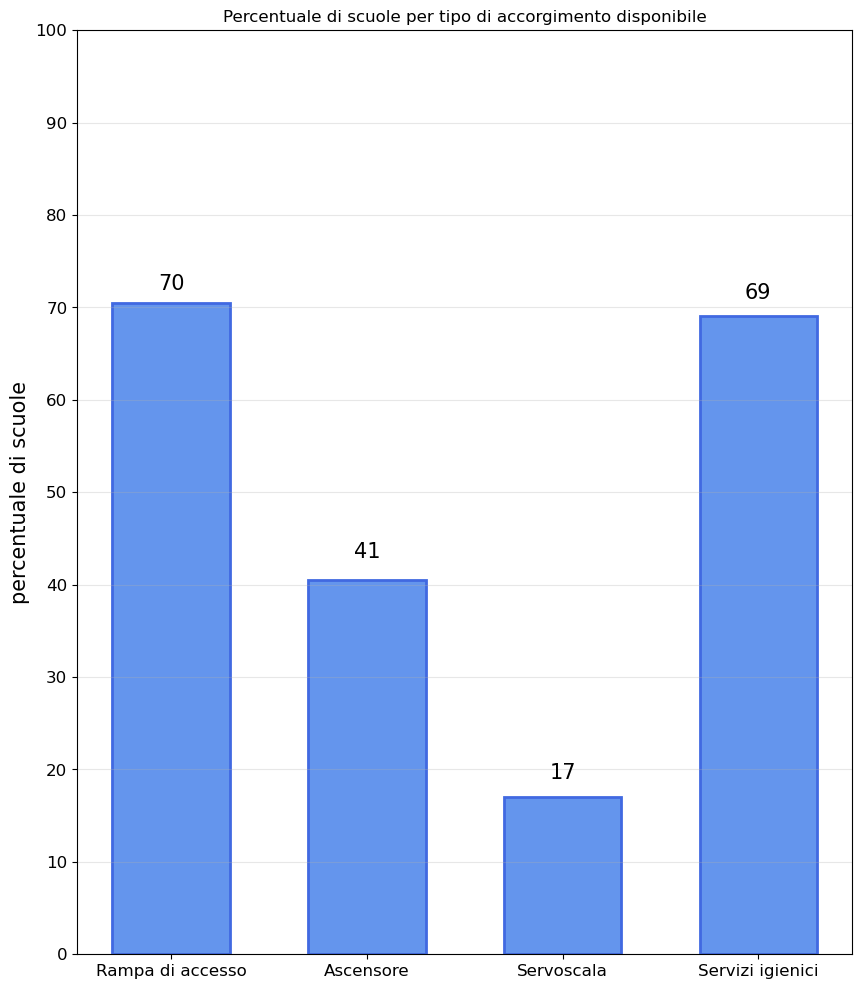

In [9]:
fig, ax = plt.subplots(figsize=(10,12))

plt.ylim([0, 100])

labels = ['Rampa di accesso', 'Ascensore', 'Servoscala', 'Servizi igienici']
percentuali = [
    len(ba_2122[ba_2122.ACCESSODAESTERNOCONRAMPE == 'SI']) / totale_scuole * 100,
    len(ba_2122[ba_2122.ASCENSORETRASPORTODISABILI == 'SI']) / totale_scuole * 100,
    len(ba_2122[ba_2122.SERVOSCALAPIATTAFORMAELEVATRICE == 'SI']) / totale_scuole * 100,
    len(ba_2122[ba_2122.SERVIZIIGIENICISPECIFICINORMADISABILI == 'SI']) / totale_scuole * 100]

plt.ylabel("percentuale di scuole", fontsize=15)
plt.yticks(np.arange(0, 105, 10), fontsize=12)
plt.xticks( fontsize = 12)
plt.grid(alpha=0.3, axis='y')
plt.title("Percentuale di scuole per tipo di accorgimento disponibile")

bars = plt.bar(labels, percentuali, 0.6, color='cornflowerblue', edgecolor='royalblue', linewidth=2)
autolabel(bars)

## Piechart - confronto tra scuole con accorgimenti e senza accorgimenti

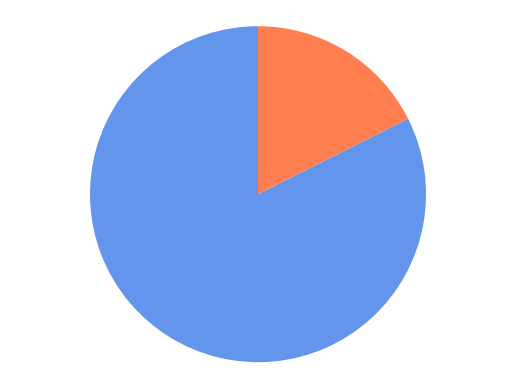

accorgimenti= 82.42529595563965 
no accorgimenti= 17.574704044360345


In [10]:
labels = 'acorgimenti', 'nessun accorgimento'
percentuale = len(ba_2122[ba_2122.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']) / totale_scuole * 100
sizes = [percentuale, 100-percentuale]

fig1, ax1 = plt.subplots()
ax1.pie(sizes,  startangle=90, colors=["cornflowerblue", "coral"])
#ax1.pie(sizes,  startangle=90, autopct='%1.1f%%', colors=["cornflowerblue", "coral"])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print("accorgimenti=", percentuale, "\nno accorgimenti=", 100-percentuale)

### Linechart

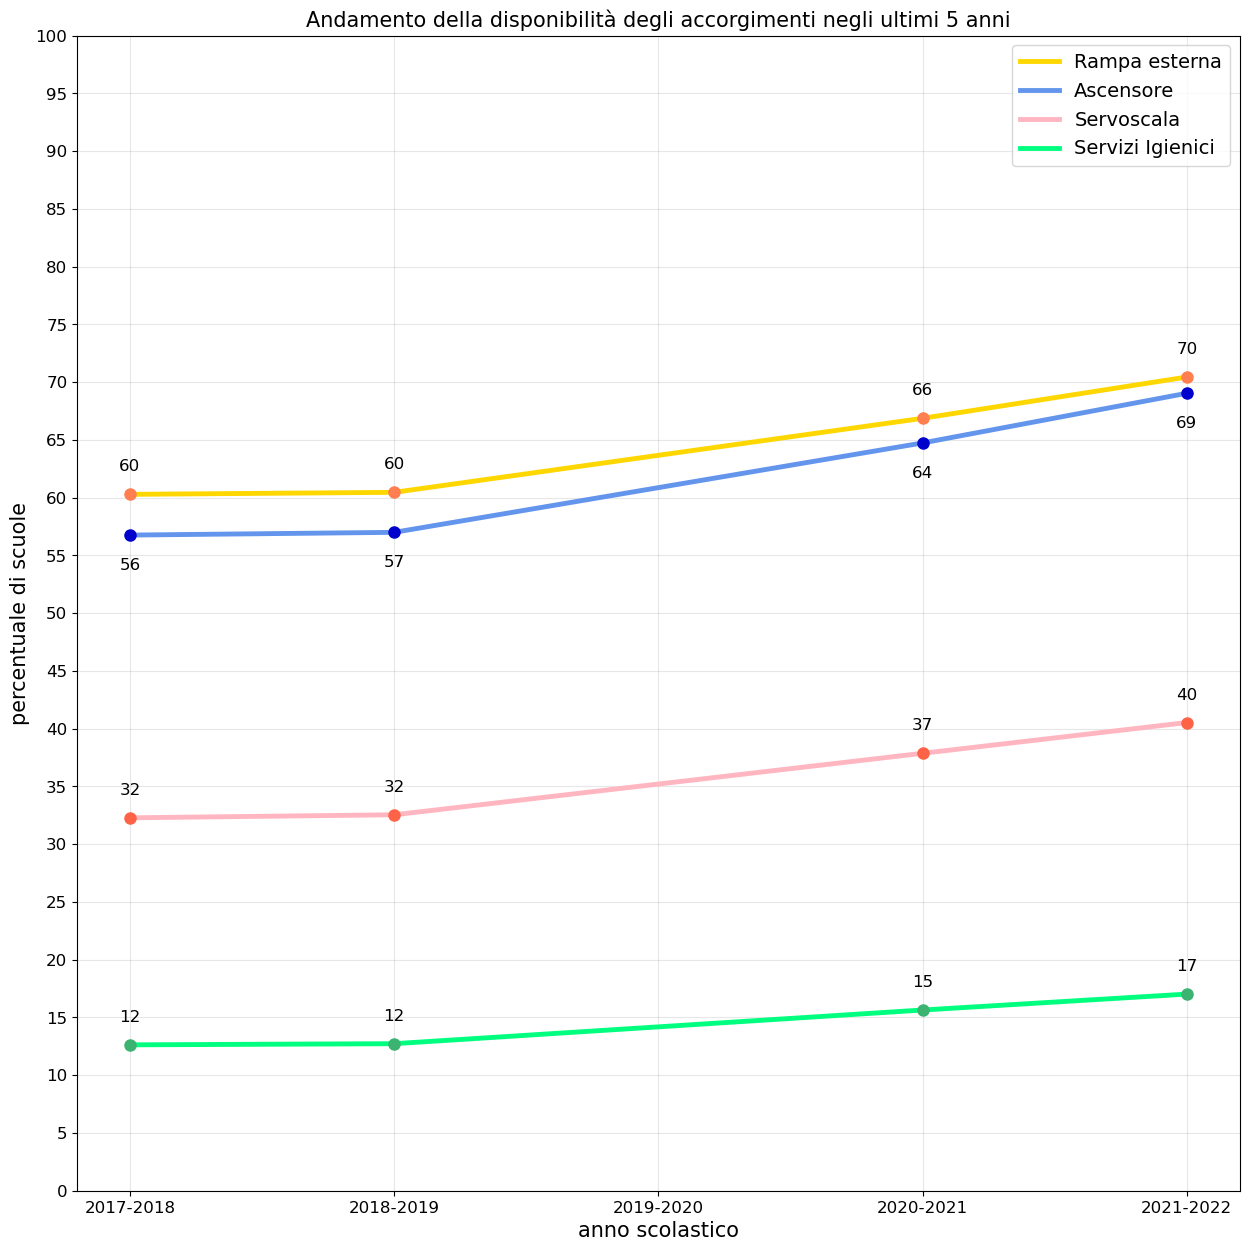

In [11]:
percentuali_1718 = [
    len(ba_1718[ba_1718.ACCESSODAESTERNOCONRAMPE == 'SI']) / len(ba_1718) * 100,
    len(ba_1718[ba_1718.SERVIZIIGIENICISPECIFICINORMADISABILI == 'SI']) / len(ba_1718) * 100,
    len(ba_1718[ba_1718.ASCENSORETRASPORTODISABILI == 'SI']) / len(ba_1718) * 100,
    len(ba_1718[ba_1718.SERVOSCALAPIATTAFORMAELEVATRICE == 'SI']) / len(ba_1718) * 100]

percentuali_1819 = [
    len(ba_1819[ba_1819.ACCESSODAESTERNOCONRAMPE == 'SI']) / len(ba_1819) * 100,
    len(ba_1819[ba_1819.SERVIZIIGIENICISPECIFICINORMADISABILI == 'SI']) / len(ba_1819) * 100,
    len(ba_1819[ba_1819.ASCENSORETRASPORTODISABILI == 'SI']) / len(ba_1819) * 100,
    len(ba_1819[ba_1819.SERVOSCALAPIATTAFORMAELEVATRICE == 'SI']) / len(ba_1819) * 100]

percentuali_2021 = [
    len(ba_2021[ba_2021.ACCESSODAESTERNOCONRAMPE == 'SI']) / len(ba_2021) * 100,
    len(ba_2021[ba_2021.SERVIZIIGIENICISPECIFICINORMADISABILI == 'SI']) / len(ba_2021) * 100,
    len(ba_2021[ba_2021.ASCENSORETRASPORTODISABILI == 'SI']) / len(ba_2021) * 100,
    len(ba_2021[ba_2021.SERVOSCALAPIATTAFORMAELEVATRICE == 'SI']) / len(ba_2021) * 100]

percentuali_2122 = [
    len(ba_2122[ba_2122.ACCESSODAESTERNOCONRAMPE == 'SI']) / len(ba_2122) * 100,
    len(ba_2122[ba_2122.SERVIZIIGIENICISPECIFICINORMADISABILI == 'SI']) / len(ba_2122) * 100,
    len(ba_2122[ba_2122.ASCENSORETRASPORTODISABILI == 'SI']) / len(ba_2122) * 100,
    len(ba_2122[ba_2122.SERVOSCALAPIATTAFORMAELEVATRICE == 'SI']) / len(ba_2122) * 100]

labels_fonti = ['Rampa esterna', 
                'Ascensore', 
                'Servoscala', 
                'Servizi Igienici']
colors = [
    'gold',
    'cornflowerblue',
    'lightpink',
    'springgreen']

color_marker = [
    'coral',
    'mediumblue',
    'tomato',
    'mediumseagreen']

labels = ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022']

fig, ax = plt.subplots(figsize=(15,15))
plt.ylim([0, 100])
plt.grid(alpha=0.3)
plt.yticks(np.arange(0, 104, 5), fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel("percentuale di scuole", fontsize=15)
plt.xlabel("anno scolastico", fontsize=15)
plt.title("Andamento della disponibilità degli accorgimenti negli ultimi 5 anni", fontsize=15)


for i in range(len(percentuali_1718)):
    lines = [percentuali_1718[i], percentuali_1819[i], (percentuali_2021[i]+percentuali_1819[i])/2, percentuali_2021[i], percentuali_2122[i]]
    dots = [percentuali_1718[i], percentuali_1819[i], None, percentuali_2021[i], percentuali_2122[i]]
    plt.plot(labels, lines, linestyle='-', color=colors[i], linewidth=3.5, label=labels_fonti[i])
    plt.plot(labels, dots, marker='o', color=color_marker[i], linestyle="None", markersize=8)
    
    offset = 2
    if i == 1: offset = -3
    for i, v in enumerate(dots):
        if v == None: continue
        ax.text(i, v + offset, "%d" %v, ha="center", size = 12)
        
plt.legend(fontsize=14)  
plt.show()

## Cartine

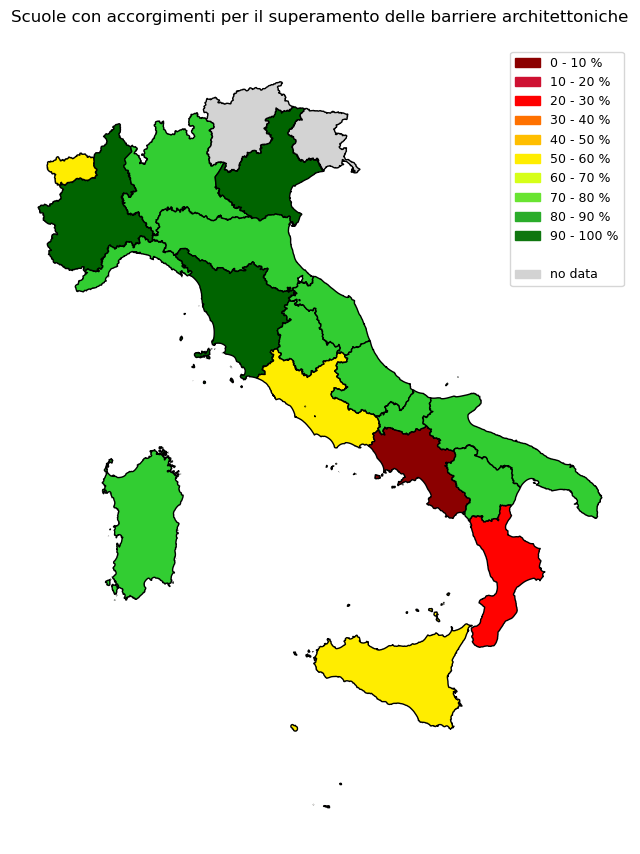

In [12]:
def get_accorgimenti(regione):
    scuole_regione = get_scuole_by_region(regione, ba_2122, elenco_province )
    if(len(scuole_regione) == 0): return 0
    scuole_regione_rampe = scuole_regione[scuole_regione.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']
    return len(scuole_regione_rampe) / len(scuole_regione) * 100

cartina(get_accorgimenti, shape_regioni, 'Scuole con accorgimenti per il superamento delle barriere architettoniche')

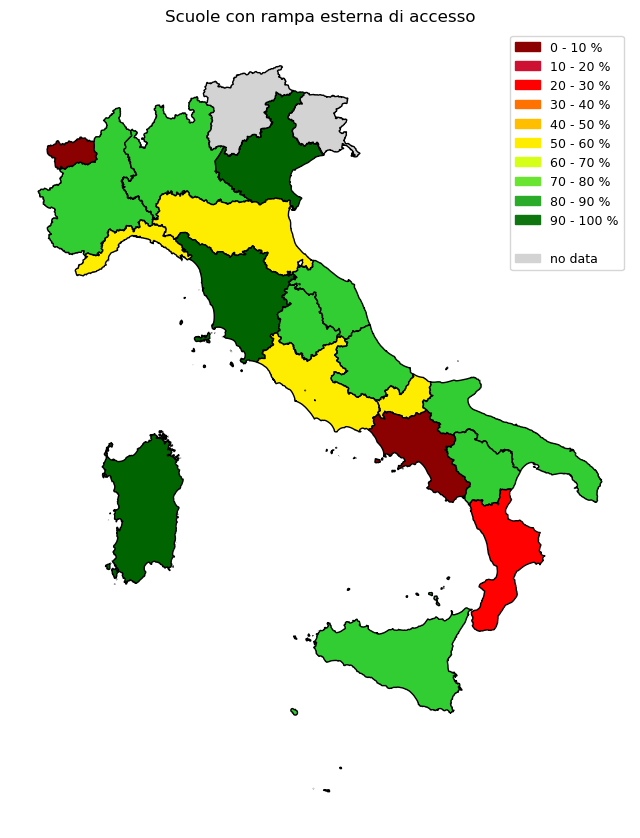

In [13]:
def get_rampe(regione):
    scuole_regione = get_scuole_by_region(regione, ba_2122, elenco_province )
    if(len(scuole_regione) == 0): return 0
    scuole_regione_rampe = scuole_regione[scuole_regione.ACCESSODAESTERNOCONRAMPE == 'SI']
    return len(scuole_regione_rampe) / len(scuole_regione) * 100

cartina(get_rampe, shape_regioni, 'Scuole con rampa esterna di accesso')

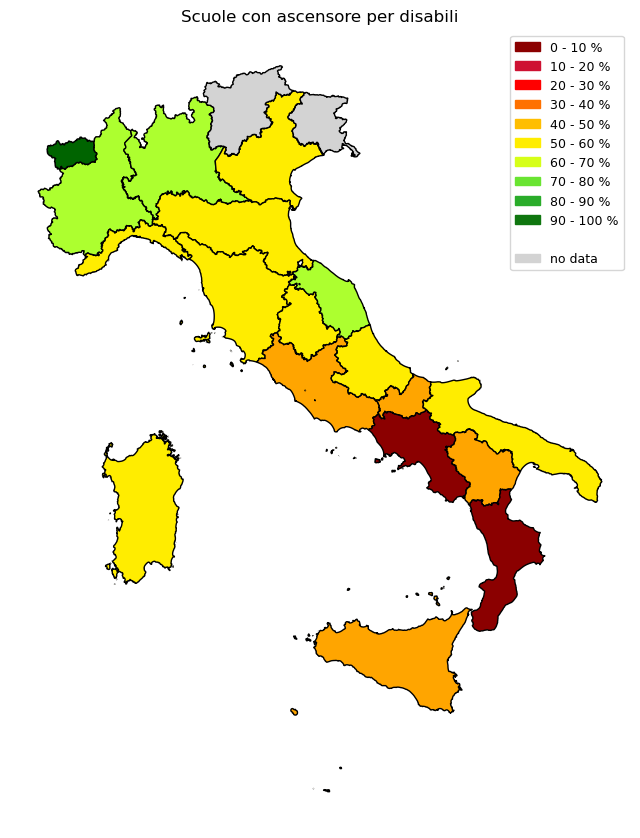

In [14]:
def get_ascensori(regione):
    scuole_regione = get_scuole_by_region(regione, ba_2122, elenco_province )
    if(len(scuole_regione) == 0): return 0
    scuole_regione_rampe = scuole_regione[scuole_regione.ASCENSORETRASPORTODISABILI == 'SI']
    return len(scuole_regione_rampe) / len(scuole_regione) * 100

cartina(get_ascensori, shape_regioni, 'Scuole con ascensore per disabili')

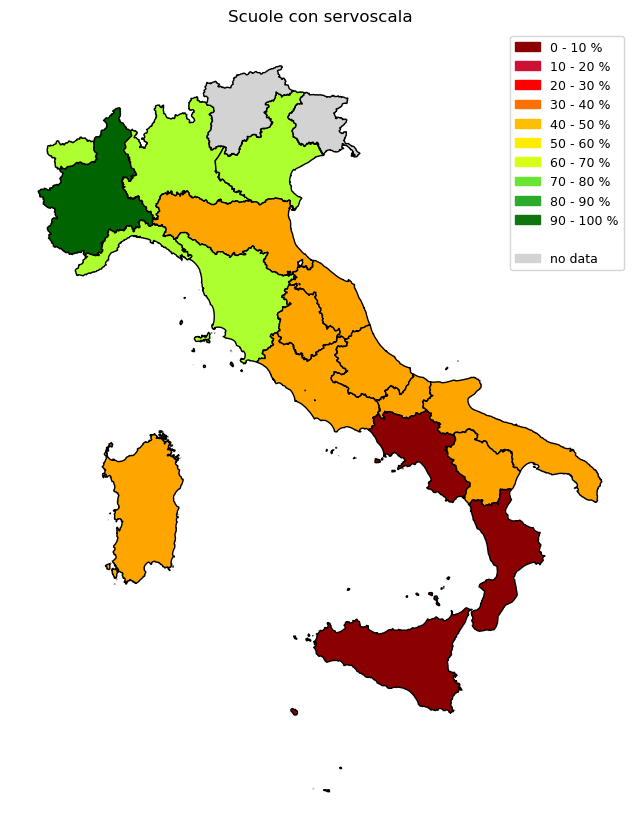

In [15]:
def get_servoscala(regione):
    scuole_regione = get_scuole_by_region(regione, ba_2122, elenco_province )
    if(len(scuole_regione) == 0): return 0
    scuole_regione_rampe = scuole_regione[scuole_regione.SERVOSCALAPIATTAFORMAELEVATRICE == 'SI']
    return len(scuole_regione_rampe) / len(scuole_regione) * 100

cartina(get_servoscala, shape_regioni, 'Scuole con servoscala')

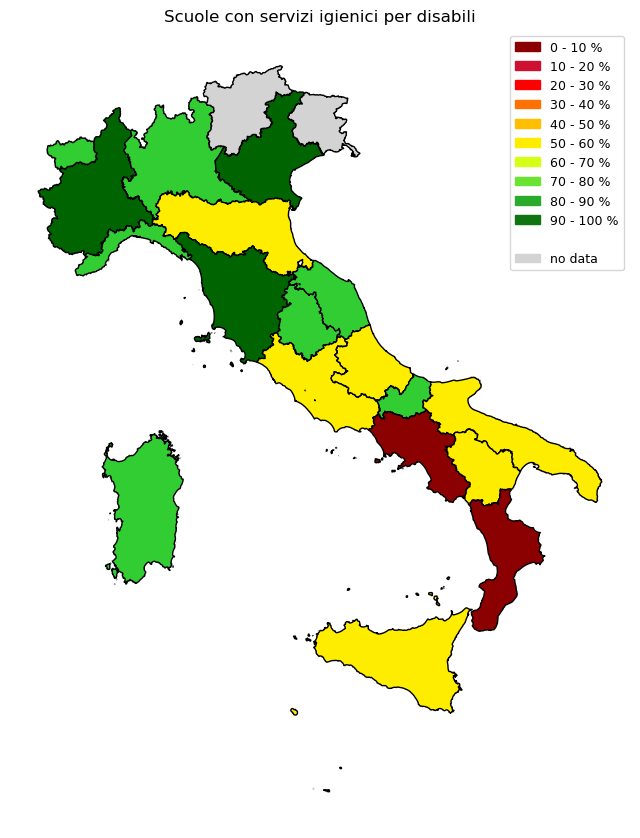

In [16]:
def get_servizi_igienici(regione):
    scuole_regione = get_scuole_by_region(regione, ba_2122, elenco_province )
    if(len(scuole_regione) == 0): return 0
    scuole_regione_rampe = scuole_regione[scuole_regione.SERVIZIIGIENICISPECIFICINORMADISABILI == 'SI']
    return len(scuole_regione_rampe) / len(scuole_regione) * 100

cartina(get_servizi_igienici, shape_regioni, 'Scuole con servizi igienici per disabili')

### Campania

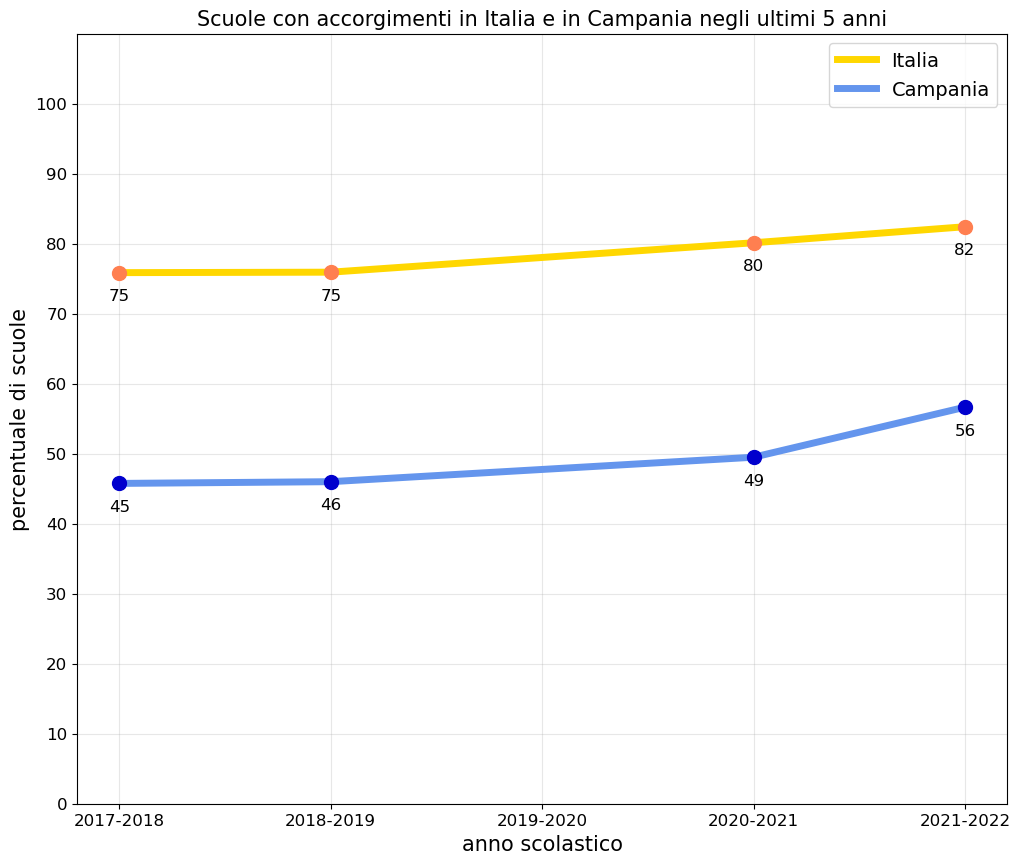

CAMPANIA:
%2017-18= 45.7578646329838 
%2021-22= 56.64365832614323
+ 10.885793693159435 %

MEDIA ITALIA:
%2017-18= 75.86868737225186 
%2021-22= 82.42529595563965
+ 6.556608583387799 %

MA nell'ultimo anno Campania: + 7.143325214884072 %
Media Italia: + 2.2877284001436493 %



In [17]:
def get_accorgimenti_campania(dataset):
    scuole_regione = get_scuole_by_region('Campania', dataset, elenco_province)
    if(len(scuole_regione) == 0): return 0
    scuole_regione_rampe = scuole_regione[scuole_regione.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']
    return len(scuole_regione_rampe) / len(scuole_regione) * 100


italia_line = [
    len(ba_1718[ba_1718.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']) / len(ba_1718) * 100,
    len(ba_1819[ba_1819.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']) / len(ba_1819) * 100,
    (len(ba_2021[ba_2021.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']) / len(ba_2021) * 100 +
    len(ba_1819[ba_1819.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']) / len(ba_1819) * 100) / 2,
    len(ba_2021[ba_2021.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']) / len(ba_2021) * 100,
    len(ba_2122[ba_2122.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']) / len(ba_2122) * 100 ]

italia_dots = [
    len(ba_1718[ba_1718.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']) / len(ba_1718) * 100,
    len(ba_1819[ba_1819.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']) / len(ba_1819) * 100,
    None,
    len(ba_2021[ba_2021.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']) / len(ba_2021) * 100,
    len(ba_2122[ba_2122.ACCORGIMENTISUPERAMENTOBARRIEREARCHITETTONICHE == 'SI']) / len(ba_2122) * 100 ]

campania_line = [
    get_accorgimenti_campania(ba_1718),
    get_accorgimenti_campania(ba_1819),
    (get_accorgimenti_campania(ba_2021) + get_accorgimenti_campania(ba_1819)) / 2,
    get_accorgimenti_campania(ba_2021),
    get_accorgimenti_campania(ba_2122) ]

campania_dots = [
    get_accorgimenti_campania(ba_1718),
    get_accorgimenti_campania(ba_1819),
    None,
    get_accorgimenti_campania(ba_2021),
    get_accorgimenti_campania(ba_2122) ]

years_labels = ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022'] 


fig, ax = plt.subplots(figsize=(12,10))
plt.ylim([0, 100])

#media
plt.plot(years_labels, italia_line, linestyle='-', color='gold', linewidth=5, label='Italia')
plt.plot(years_labels, italia_dots, marker='o', color='coral', linestyle="None", markersize=10)

for i, v in enumerate(italia_dots):
    if v == None: continue
    ax.text(i, v -4, "%d" %v, ha="center", size = 12)

#campania
plt.plot(years_labels, campania_line, linestyle='-', color='cornflowerblue', linewidth=5, label='Campania')
plt.plot(years_labels, campania_dots, marker='o', color='mediumblue', linestyle="None", markersize=10)
plt.grid(alpha=0.3)
plt.yticks(np.arange(0, 105, 10), fontsize=12)
plt.ylim([0, 110])
plt.xticks(fontsize=12)
plt.ylabel("percentuale di scuole", fontsize=15)
plt.xlabel("anno scolastico", fontsize=15)
plt.legend(fontsize=14)
plt.title("Scuole con accorgimenti in Italia e in Campania negli ultimi 5 anni", fontsize=15)

for i, v in enumerate(campania_dots):
    if v == None: continue
    ax.text(i, v - 4, "%d" %v, ha="center", size = 12)

plt.show()
    
print("CAMPANIA:\n%2017-18=", campania_dots[0], "\n%2021-22=", campania_dots[4])
print("+", campania_dots[4] - campania_dots[0], "%\n" )

print("MEDIA ITALIA:\n%2017-18=", italia_dots[0] , "\n%2021-22=", italia_dots[4])
print("+", italia_dots[4] - italia_dots[0], "%\n" )

print("MA nell'ultimo anno Campania: +", campania_dots[4] - campania_dots[3], "%" )
print("Media Italia: +", italia_dots[4] - italia_dots[3], "%\n" )